# Hluttaw Statistics

In [12]:
import requests
import json

#Getting total number of pages via REST request
page_request = requests.get('http://api.openhluttaw.org/en/persons')
pages = page_request.json()['num_pages']

#Fetch and build list of all representatives
persons =[]
for page in range(1,pages+1):
    req_representatives = requests.get('http://api.openhluttaw.org/en/persons?page='+str(page))
    for person in json.loads(req_representatives.content)['results']:
        persons.append(person)
        


In [23]:
import datetime
from dateutil import parser

def age(str):
    #calculate age based on date strings stored in Popit
    born = parser.parse(str)
    today = datetime.date.today()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day)) 
    return int(age)

for person in persons:
    if person['birth_date']:
        person['age'] = age(person['birth_date'])

## Age Stats

In [35]:
import pandas
data = { "age": [], "birth_date":[] }
data_index = { "age": [], "birth_date":[]}

for entry in persons:
    if entry.has_key('age'):
        data["age"].append(entry["age"])
        data_index["age"].append(entry["name"])
        data["birth_date"].append(entry["birth_date"])
        data_index["birth_date"].append(entry["name"])
        

final_data = { "age": pandas.Series(data["age"], index=data_index["age"]),
                "birth_date": pandas.Series(data["birth_date"], index=data_index["birth_date"])
             }
persons_age_df = pandas.DataFrame(final_data)
persons_age_df.sort_values(by="age")

print "Median:" + " " + str(persons_age_df['age'].median())
print "Youngest:" + " " + str(persons_age_df['age'].min())
print "Oldest:" + " " + str(persons_age_df['age'].max())

Median: 55.0
Youngest: 27
Oldest: 81


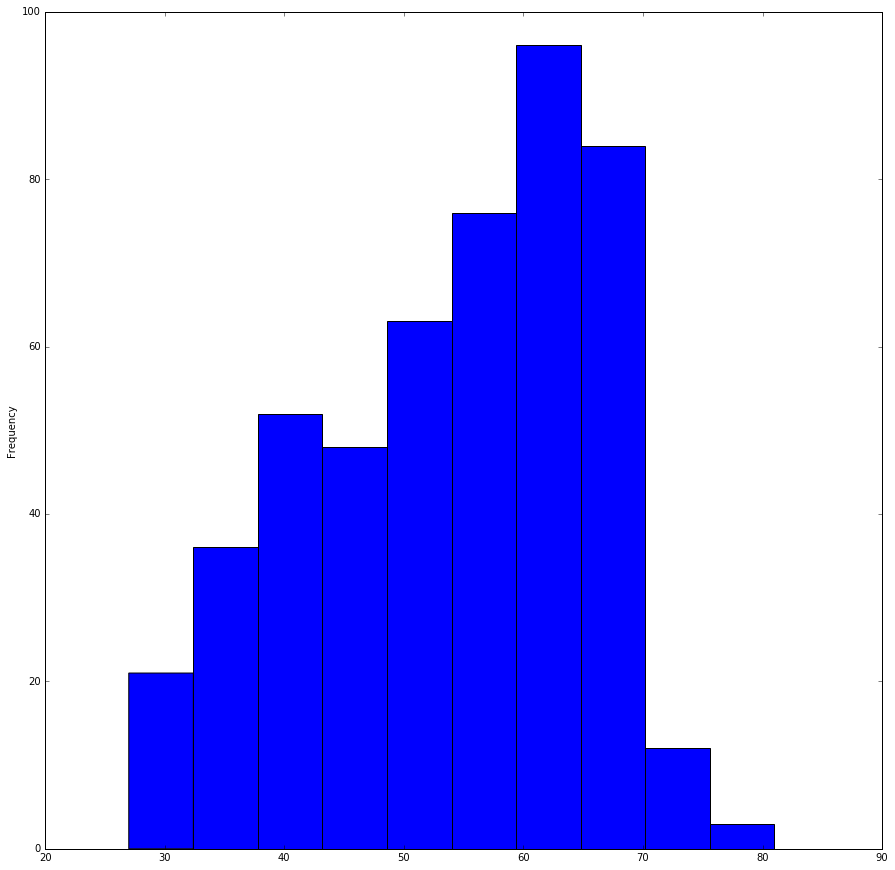

In [32]:
%matplotlib inline 
persons_age_df["age"].plot(kind="hist",figsize=(15,15))

# Gender

In [46]:
women_reps = []
for person in persons:
    if person['gender'] == 'female':
        women_reps.append(person)

print "Number of Women reps " + str(len(women_reps))     

print "Percentage of Women representatives " + "{0:.2f}".format(65/498.0*100)+"%"

Number of Women reps 65
Percentage of Women representatives 13.05%
